In [1]:
# Imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency, pointbiserialr
from sklearn.metrics import matthews_corrcoef
import numpy as np
from sklearn import preprocessing
import math

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
dir_data = '../data/raw/'

# File names
filename_train_features = 'train_values.csv'

# Create paths for given files
filepath_train_features = os.path.join(dir_data, filename_train_features)

# Check if files and data folder exist
if not os.path.isdir(dir_data):
    raise FileNotFoundError("Data directory is missing")
if not len(os.listdir(dir_data)):
    raise FileNotFoundError("Files missing")

if not filepath_train_features:
    raise FileNotFoundError(f"{filename_train_features} is missing.")

# Load data
train_features = pd.read_csv(filepath_train_features)

# Take a first look at the data

In [4]:
train_features.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id   
0       802906               6             487           12198  \
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage   
0                    2   30                6                  5  \
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture   
0                      t               r  ...                             0  \
1                      o               r  ...                             0   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental   
0                       0                        0  \
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   

  has_secondary_use_institution has_secondary_use_school   
0                             0                        0  \
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post   
0                           0                              0  \
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   has_secondary_use_gov_office  has_secondary_use_use_police   
0                             0                             0  \
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   has_secondary_use_other  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 39 columns]

In [5]:
train_features.shape

(260601, 39)

In [6]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

# Relationship between features

## Redundancies
At first we look for duplicate rows in order to drop them.

In [7]:
print(f"Shape before dropping duplicates: {train_features.shape}")
train_features = train_features.drop_duplicates()
print(f"Shape after dropping duplicates : {train_features.drop_duplicates().shape}")

Shape before dropping duplicates: (260601, 39)
Shape after dropping duplicates : (260601, 39)


There is the same number of rows, so there are no duplicate rows.
If there were duplicates it would be interesting to see whether they have the same label. 

## Correlation
Correlation between the features, depending on the data type choose different measures

According to the documentation there are features of type:
- int
- binary (=bin)
- categorical (=cat)

I will test following measures for the respective combinations:

| Type 1 | Type 2 | Measure  |
|--------|--------|----------|
| int    | int    | Person   |
| int    | cat    | ANOVA, can also check scatter plot|
| int    | bin    | Point-Biserial |
| cat    | cat    | Contingency, Cramers V, Chi square |
| cat    | bin    |          |
| bin    | bin    | $\Phi$, Tetrachoric Correlation |

Links to some of the measures, to know where I found them:
- [Point-Biserial](https://researchbasics.education.uconn.edu/types_of_correlations/)
- [Point-Biserial example](https://dzone.com/articles/correlation-between-categorical-and-continuous-var-1)
- [Tetrachoric Correlation](https://www.statology.org/correlation-between-categorical-variables/)
- [Cramers V](https://www.statology.org/correlation-between-categorical-variables/)
- [Contingency](https://researchbasics.education.uconn.edu/types_of_correlations/)
- [$\Phi$](https://researchbasics.education.uconn.edu/types_of_correlations/)
- [ANOVA](https://thinkingneuron.com/how-to-measure-the-correlation-between-a-numeric-and-a-categorical-variable-in-python/)

A paper for the binary-binary case: [Properties of Binary Vector Dissimilarity Measures](https://cedar.buffalo.edu/papers/articles/CVPRIP03_propbina.pdf)

And also try to encode the categorical features and handle them just as numerical ones. 

In [8]:
# Define lists of features according to their datatype in the documentation
int_features = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "count_floors_pre_eq", "age", "area_percentage", "height_percentage", "count_families"]
cat_features = ["land_surface_condition", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "position", "plan_configuration", "legal_ownership_status"]
bin_features = ["has_superstructure_adobe_mud", "has_superstructure_mud_mortar_stone", "has_superstructure_stone_flag", "has_superstructure_cement_mortar_stone", "has_superstructure_mud_mortar_brick", "has_superstructure_cement_mortar_brick", "has_superstructure_timber", "has_superstructure_bamboo", "has_superstructure_rc_non_engineered", "has_superstructure_rc_engineered", "has_superstructure_other", "has_secondary_use", "has_secondary_use_agriculture", "has_secondary_use_hotel", "has_secondary_use_rental", "has_secondary_use_institution", "has_secondary_use_school", "has_secondary_use_industry", "has_secondary_use_health_post", "has_secondary_use_gov_office", "has_secondary_use_use_police", "has_secondary_use_other"]

In [9]:
# Sanity check: Do I have all features in the lists above?
# - 1 because of building_id, which is the identifier
print(len(int_features) + len(cat_features) + len(bin_features) == len(train_features.columns) - 1)

True


### Define functions

In [10]:
def plot_pearson_corr_heatmap(data=None, features_x_axis=None, features_y_axis=None):
    """
    Calculates the pearson correlation of all features and plots them in a heatmap. 
    
    :param data: Dataframe with features and values
    :param features_x_axis: The features to plot on the x axis
    :param features_y_axis: The features to plot on the y axis
    """
    # assert: data not None
    # ToDo: Check if feature sets are in the dataframe
    
    # Calculate and show correlation matrix
    corr_matrix = data.corr()

    # Set features for axis
    if features_x_axis is None: 
        features_x_axis = list(data.columns)
    if features_y_axis is None:
        features_y_axis = list(data.columns)
    
    # Plot correlations4
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix[features_x_axis].loc[features_y_axis], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [11]:
def plot_cramers_v_corr_heatmap(data=None, features_x_axis=None, features_y_axis=None, annotate_map=True):
    """
    Calculates the cramers V correlation of all features and plots them in a heatmap. 
    Cramers V is based on Chi square, for reference see: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    Note that this function is desined to work for categorical features only!
    Code was copied and modified from this source: https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook
    
    :param data: Dataframe with features and values
    :param features_x_axis: The features to plot on the x axis
    :param features_y_axis: The features to plot on the y axis
    """
    # Encode features
    label = preprocessing.LabelEncoder()
    data_encoded = pd.DataFrame() 

    for i in data.columns :
        data_encoded[i]=label.fit_transform(data[i])

    # Internal function to calculate cramers V for two features
    def _cramers_V(var1, var2) :
        crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))  # Cross table building
        stat = chi2_contingency(crosstab)[0]  # Keeping of the test statistic of the Chi2 test
        obs = np.sum(crosstab)  # Number of observations
        mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
        return (stat / (obs * mini))
        #return stat

    # Calculate values for each pair of features
    rows= []
    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers = _cramers_V(data_encoded[var1], data_encoded[var2])  # Cramer's V test
            col.append(round(cramers, 4))  # Keeping of the rounded value of the Cramer's V  
        rows.append(col)
    
    # Create a pandas df from the results
    cramers_results = np.array(rows)
    cramers_v_corr_matrix = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
    
    # Set features for axis
    if features_x_axis is None: 
        features_x_axis = list(data.columns)
    if features_y_axis is None:
        features_y_axis = list(data.columns)
    
    # Plot correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(cramers_v_corr_matrix[features_x_axis].loc[features_y_axis], annot=annotate_map, cmap=plt.cm.Reds)
    plt.show()

### Correlation between int-int features

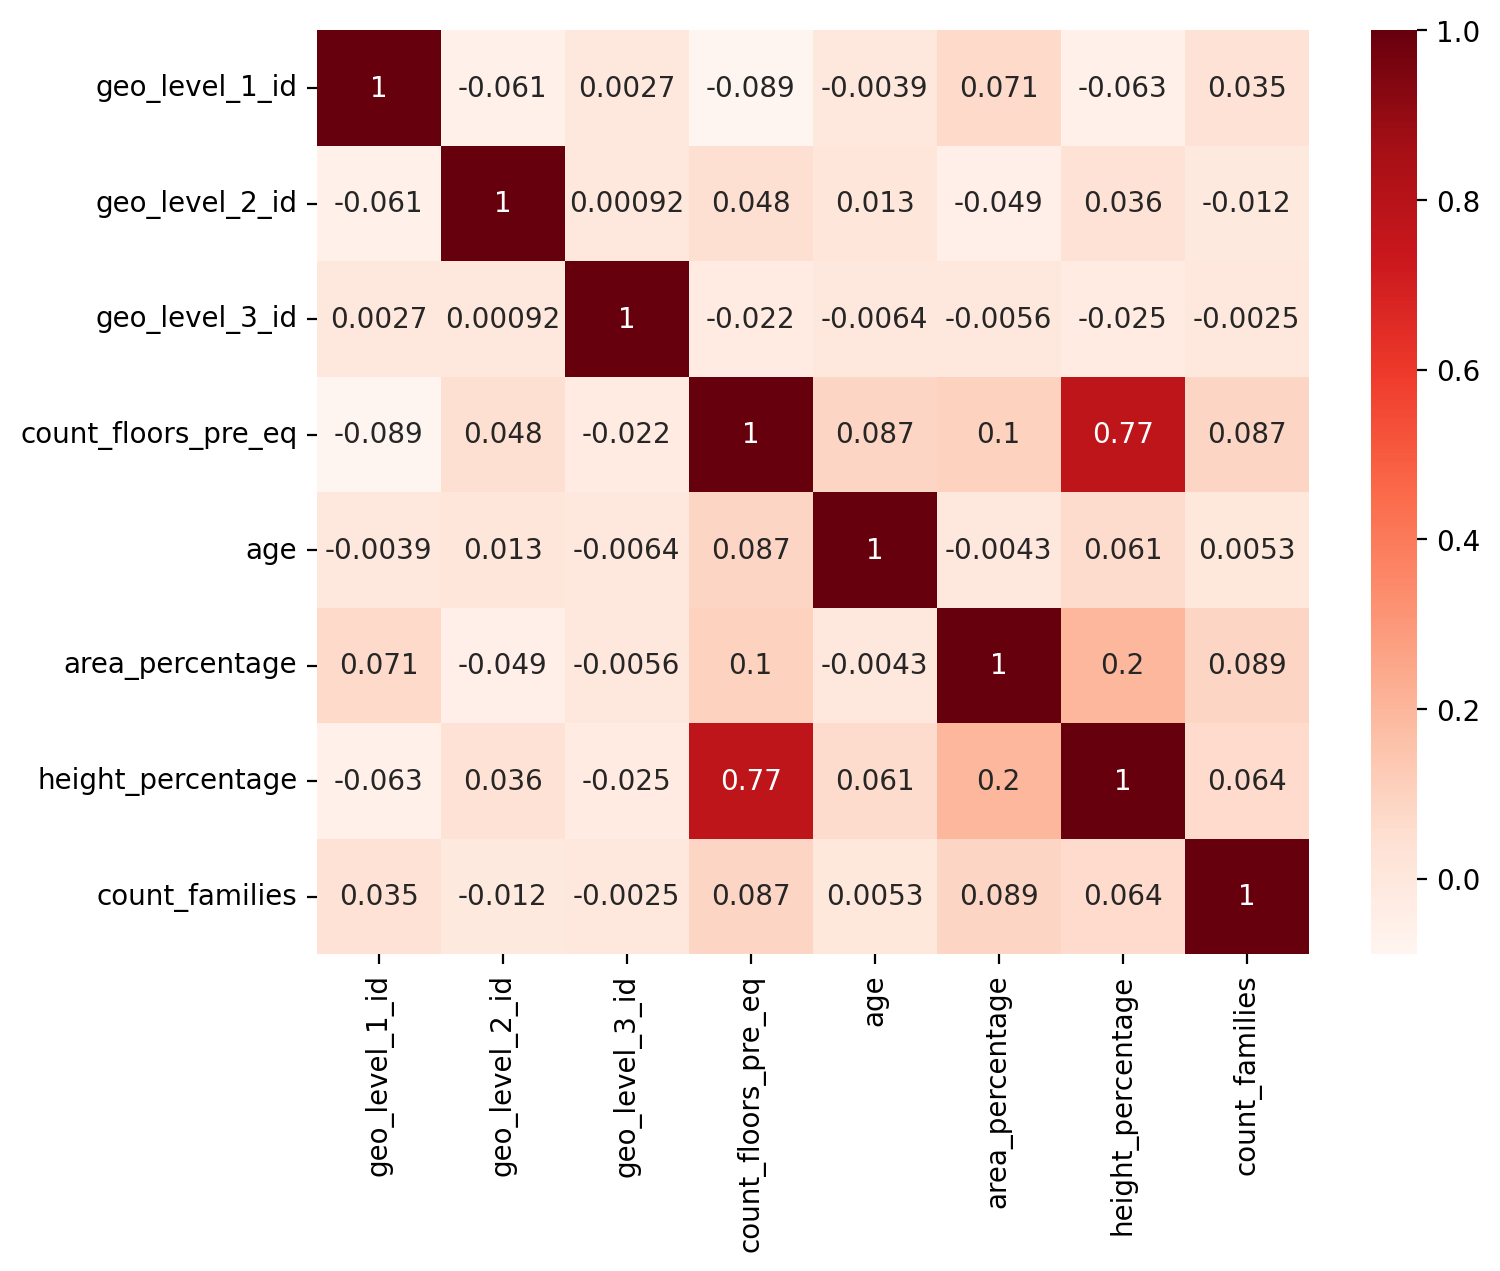

In [12]:
plot_pearson_corr_heatmap(data=train_features[int_features])

We can see a high correlation between ´´height_percentage´´ and ´´count_floors_pre_eq´´.
So there is redundant information and we can drop one of the features. 

### Correlation between int-cat features

Here I will use ANOVA, which basically checks if there are any significant differences between the means of the values of the numeric variable for each categorical value.

ANOVA has the Null-hypothesis, that the variables are not correlated with each other. 
- The p-value indicates the probability, that the Null-hypothesis is true. 
- So we can choose a confidence level e.g. 0.05. 
- If the p-value > 0.05 means variables are NOT correlated. 
- If the p-value < 0.05 means variables are correlated.

In [13]:
rows = []
cat_col = []
num_col = []
f_col = []
p_col = []

for category in cat_features:
    for num_feature in int_features:
        group_list = train_features.groupby(category)[num_feature].apply(list)
        res = f_oneway(*group_list)
        rows.append([category, num_feature, res[0], float(res[1])])
        
        if res[1] >= 0.05:
            print(f"{category} - {num_feature}")
        
# Create a pandas df from the results
anova_results = np.array(rows)
anova_results_df = pd.DataFrame(anova_results, columns=["categorical_feature", "numerical_feature", "f_statistics", "p_value"])

# Also show results
anova_results_df.head(len(int_features) * len(cat_features))

categorical_feature    numerical_feature        f_statistics   
0   land_surface_condition       geo_level_1_id  122.08813584756095  \
1   land_surface_condition       geo_level_2_id  154.20741822904256   
2   land_surface_condition       geo_level_3_id   51.42973456260621   
3   land_surface_condition  count_floors_pre_eq  282.09529540002853   
4   land_surface_condition                  age  54.755541824216124   
..                     ...                  ...                 ...   
59  legal_ownership_status  count_floors_pre_eq   833.1590153579357   
60  legal_ownership_status                  age   50.84739329409045   
61  legal_ownership_status      area_percentage   91.87344872810995   
62  legal_ownership_status    height_percentage   551.5397195531095   
63  legal_ownership_status       count_families  13.656915214419756   

                   p_value  
0   1.0060539711714172e-53  
1   1.1699516831513384e-67  
2   4.6639825441382586e-23  
3   4.168669667989398e-123  
4   1.6786705565524437e-24  
..                     ...  
59                     0.0  
60   7.619144233705199e-33  
61  2.0177383715703805e-59  
62                     0.0  
63  6.6434809733535774e-09  

[64 rows x 4 columns]

Since the p-value of EVERY(!) combination is 0 or almost 0 this means that they are all correlated!

This doesn't make sense, therefore I will look closer

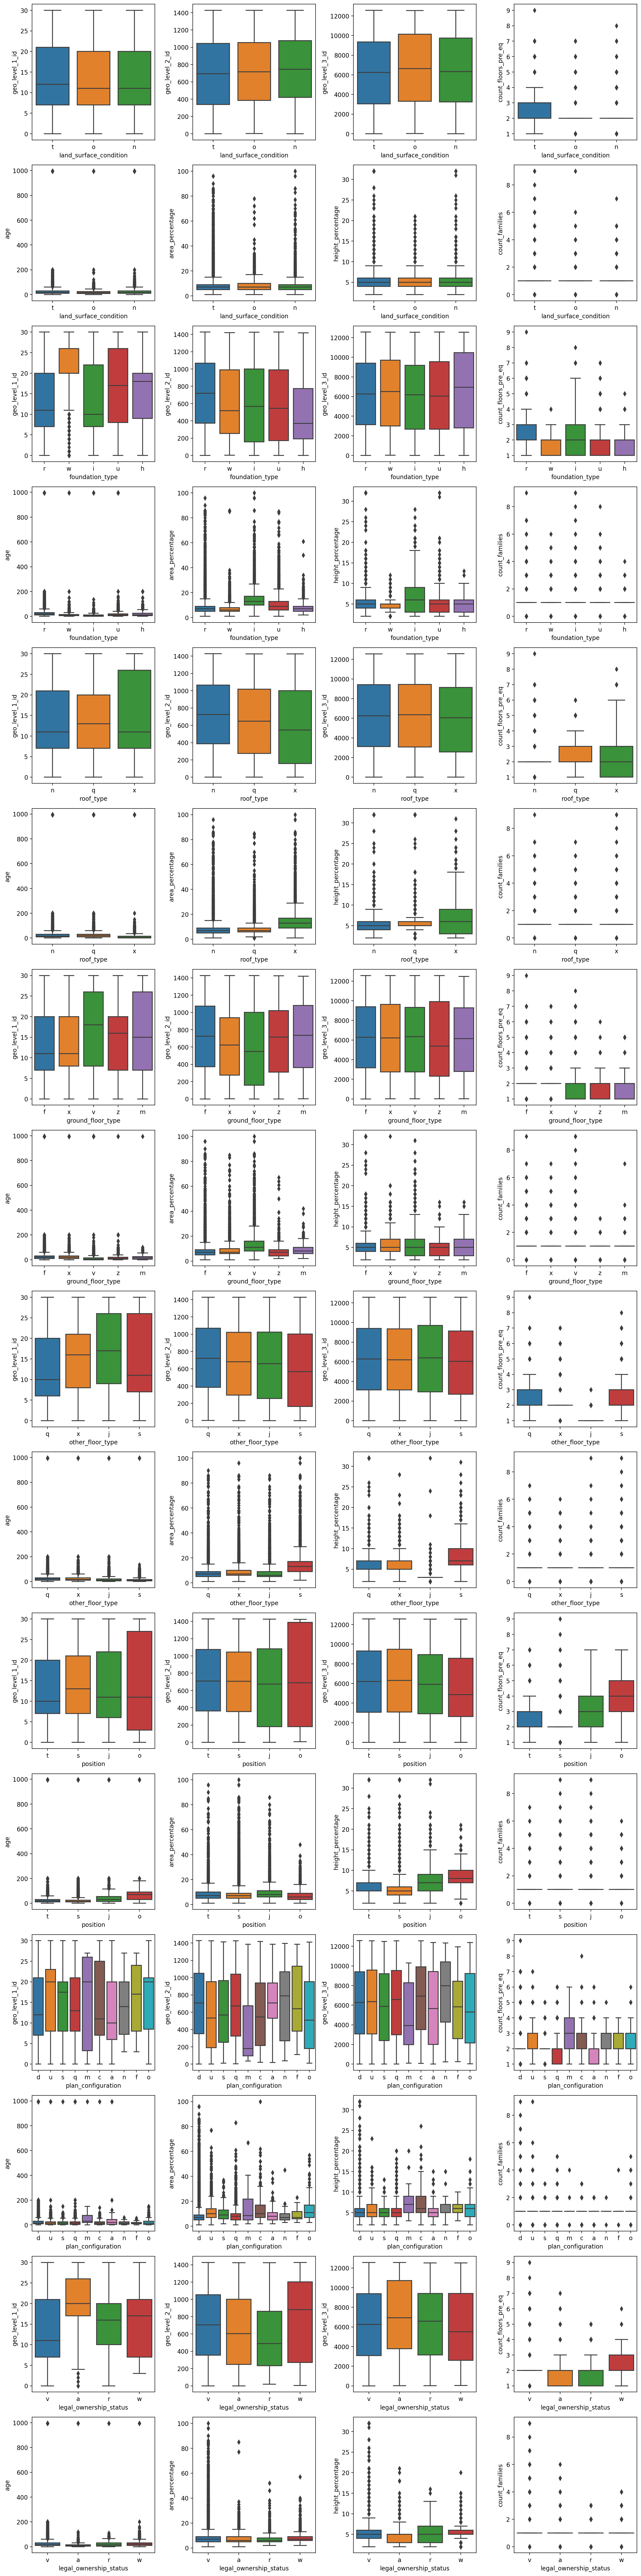

In [14]:
# Dynamically set size of subplots
columns: int = 4
rows: int = math.ceil((len(cat_features) * len(int_features))/columns)

# Plot settings
fig, axes = plt.subplots(figsize=(15, 60), nrows=rows, ncols=columns)
#fig.suptitle("Boxplots for relationship between categorical and numerical features", size=18)

# Index for axes
i = 0

# Iterate over feature combinations
for category in cat_features:
    for num_feature in int_features:
        g = sns.boxplot(data=train_features, x=category, y=num_feature, ax=axes.flatten()[i])
        i += 1

plt.tight_layout()
plt.show()

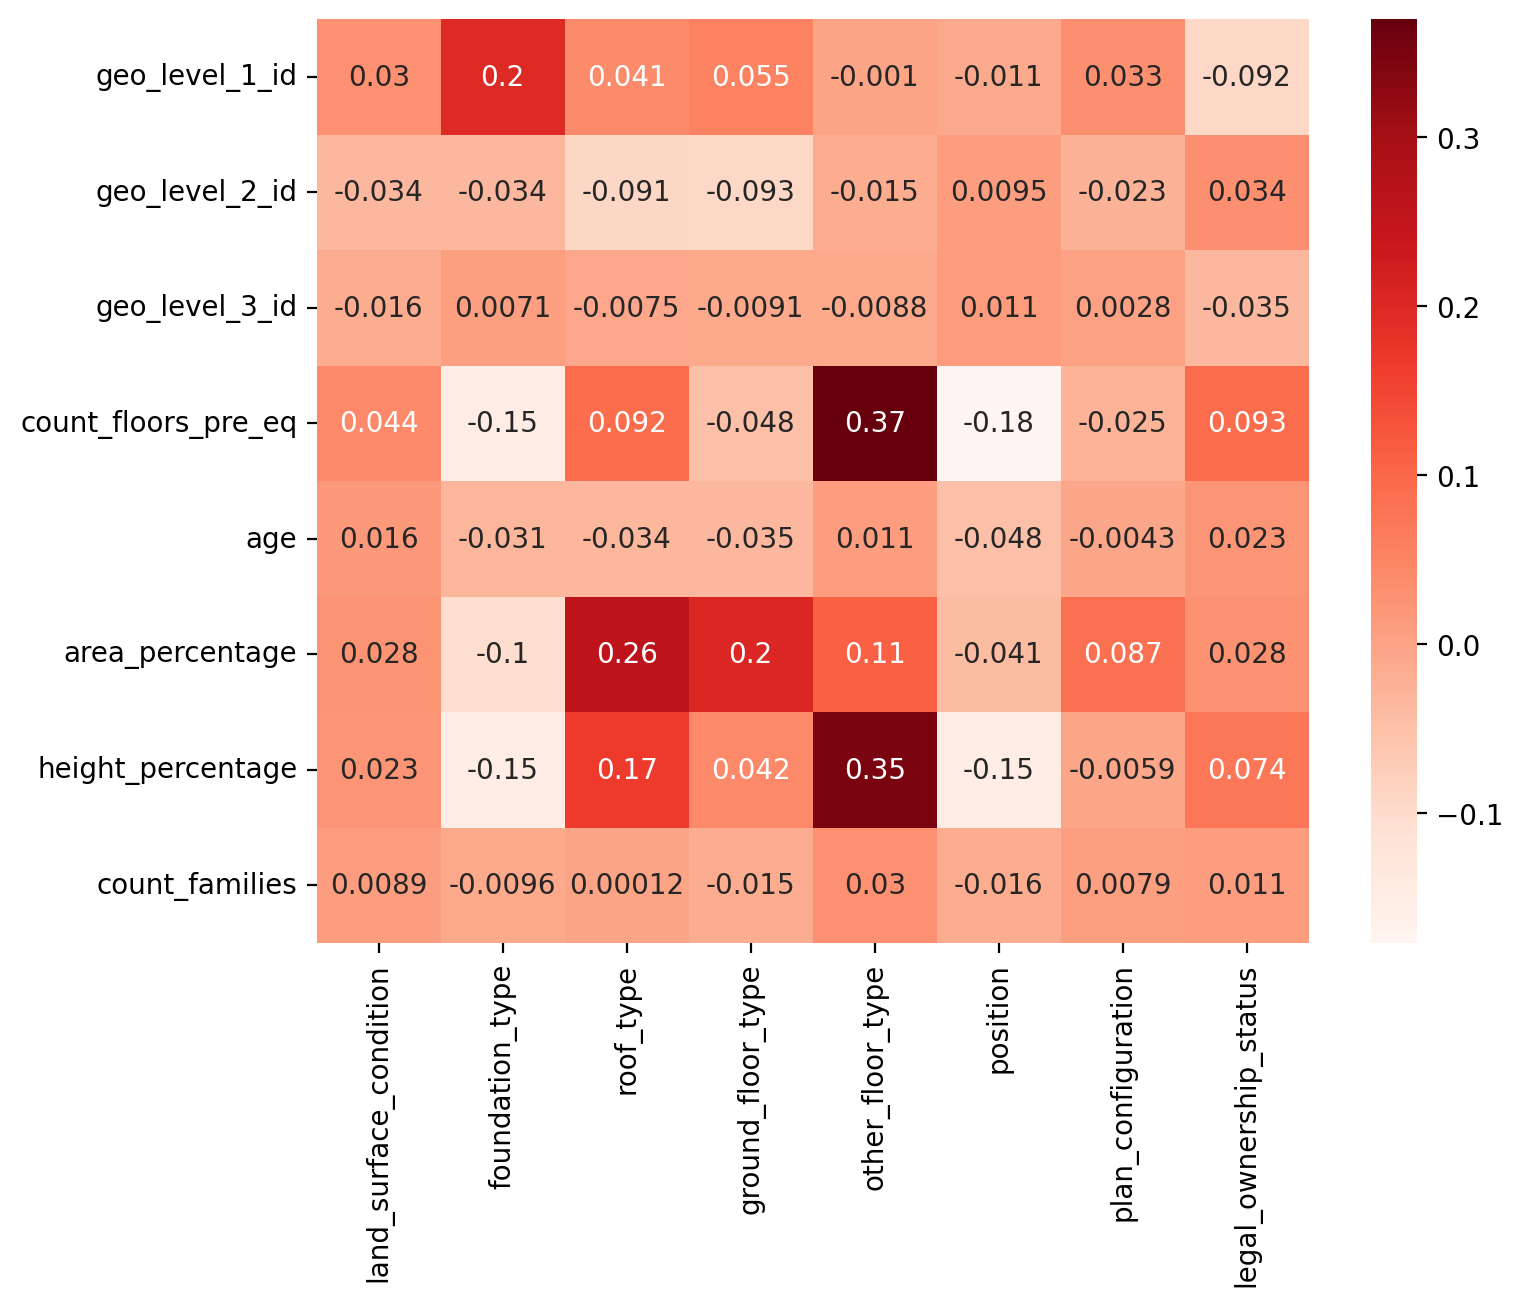

In [15]:
# Create a copy of the data set because the data types will be changed
data = train_features[cat_features + int_features].copy()

for feature in cat_features:
    data[feature] = data[feature].astype('category').cat.codes

# Calculate and show correlation matrix
corr_matrix = data.corr()

# Plot correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix[cat_features].loc[int_features], annot=True, cmap=plt.cm.Reds)
plt.show()

I found it pretty hard to analyze this kind of feature combination. 
The only measure I found is ANOVA and it suggests, that every combination of categorical and numerical feature is correlated. 

Therefore, I tried: 
- Encoding the categorical features and calculate standard pearson. This led to no significant correlation, but it also depends on the encoding of the features.
- Analyzing boxplots: Most of the numerical values are (more or less) equally or at least similar distibuted among the categories.

### Correlation between int-bin features

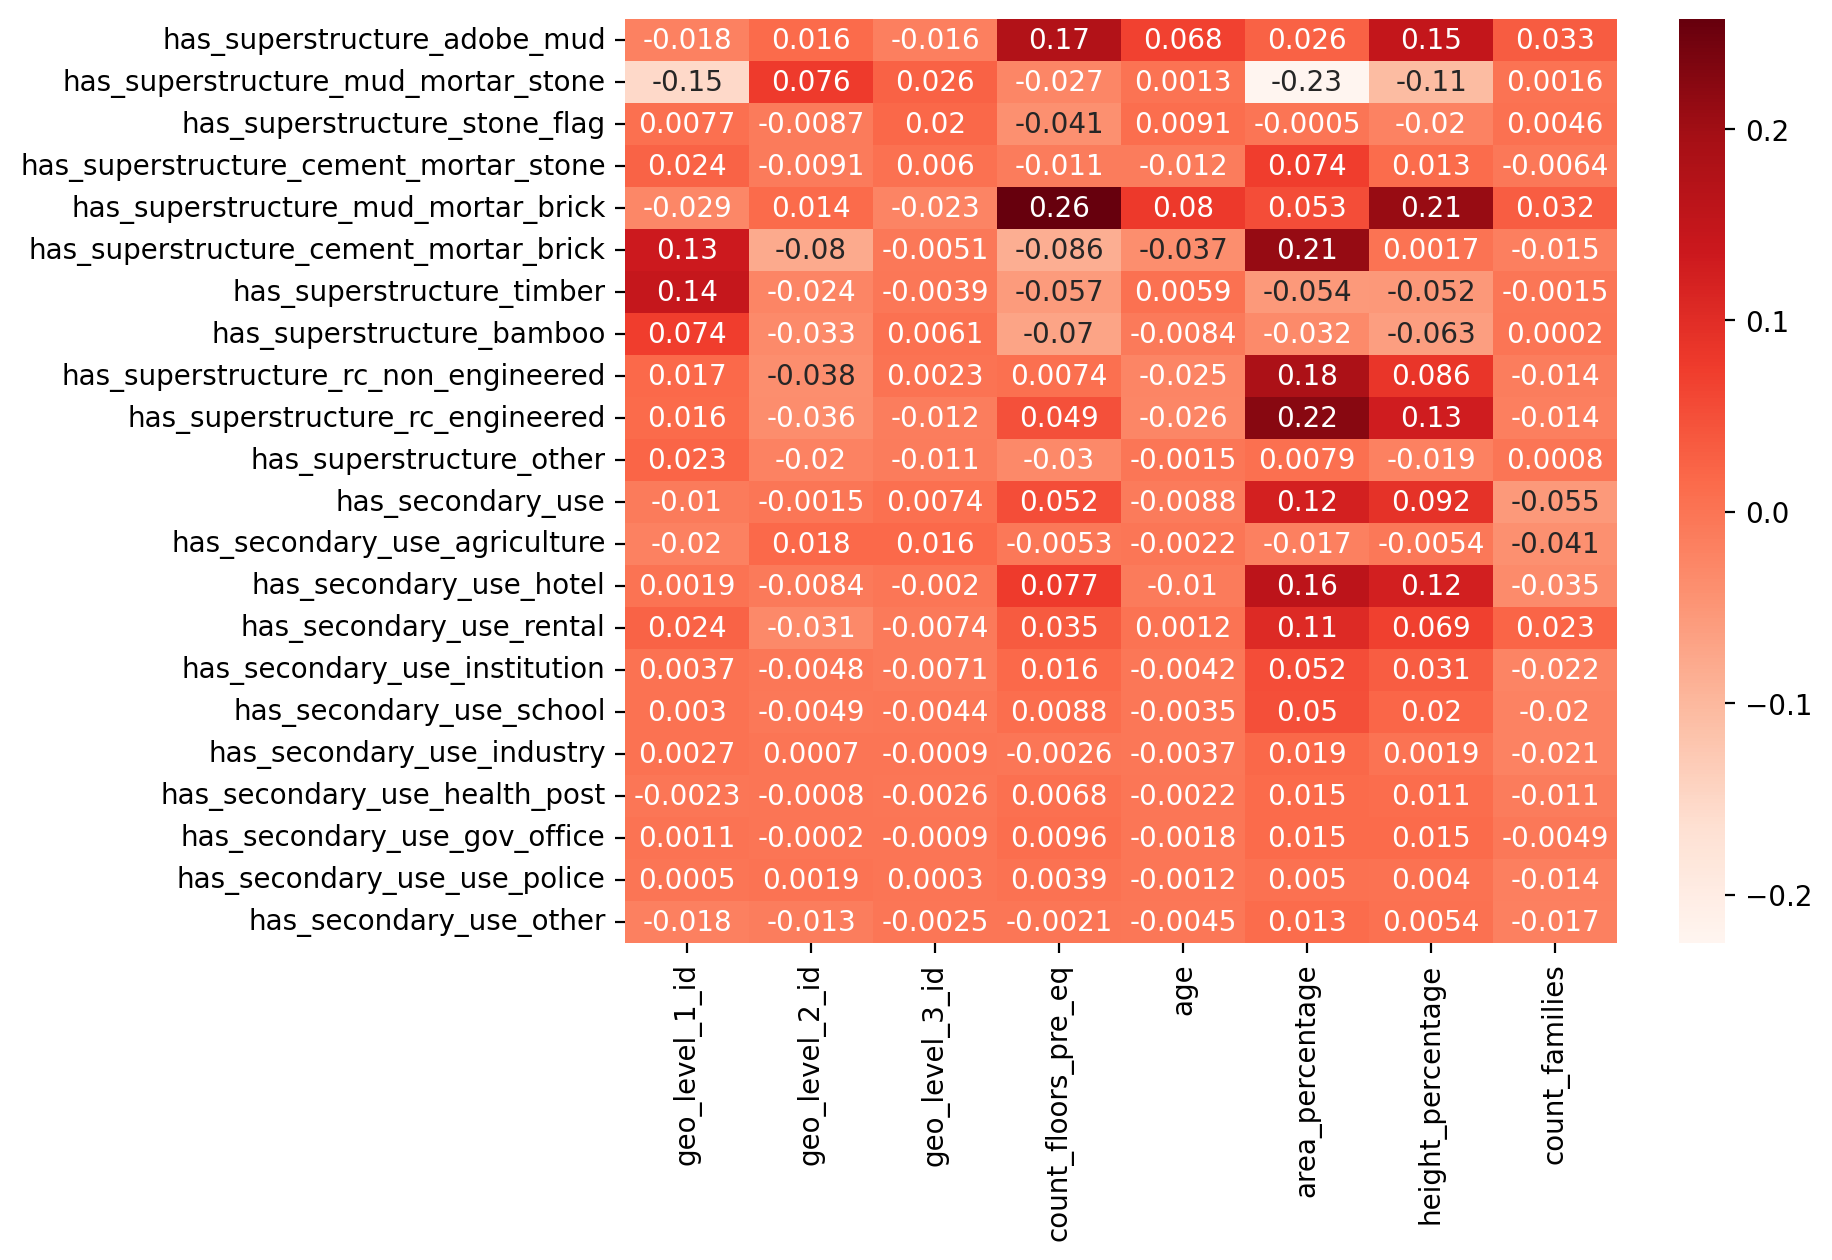

In [16]:
# Calculate point biserial correlation (in this case it is equal to pearson correlation)
rows = []
for bin_feature in bin_features:
    col = []
    for int_feature in int_features:
        pbc = pointbiserialr(train_features[bin_feature], train_features[int_feature])
        col.append(round(pbc[0], 4))
    rows.append(col)    
    
pbc_results = np.array(rows)
pbc_corr_matrix = pd.DataFrame(pbc_results, columns = int_features, index = bin_features)
    
# Plot correlations
plt.figure(figsize=(8,6))
sns.heatmap(pbc_corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

We can see, that there is no high correlation between any of the features

### Correlation between cat-cat features

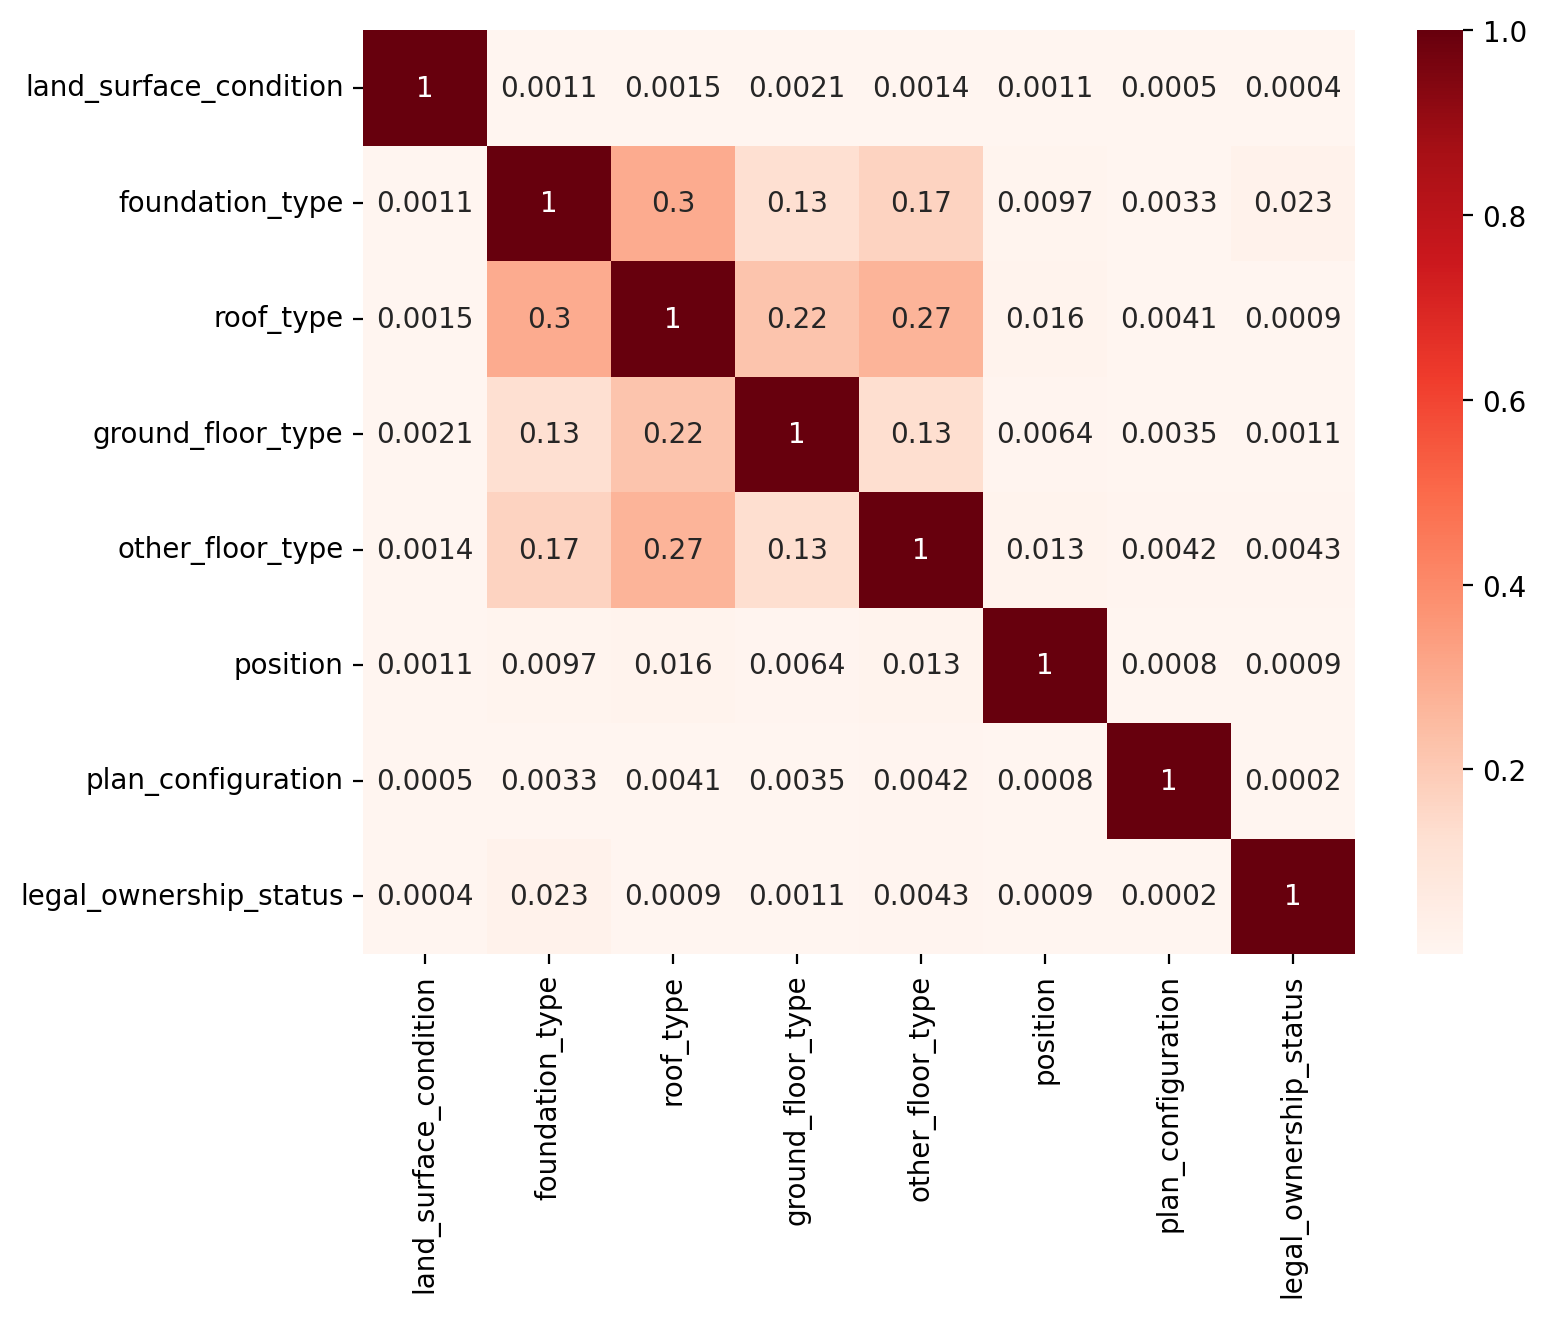

In [17]:
plot_cramers_v_corr_heatmap(train_features[cat_features])

In [18]:
for f1 in cat_features:
    for f2 in cat_features:
        phi = matthews_corrcoef(train_features[f1], train_features[f2])
        if phi > 0.5 and f1 != f2:
            print(f"'{f1}' - '{f2}': {phi}")

There is no high correlation between any of the features.

### Correlation between cat-bin features

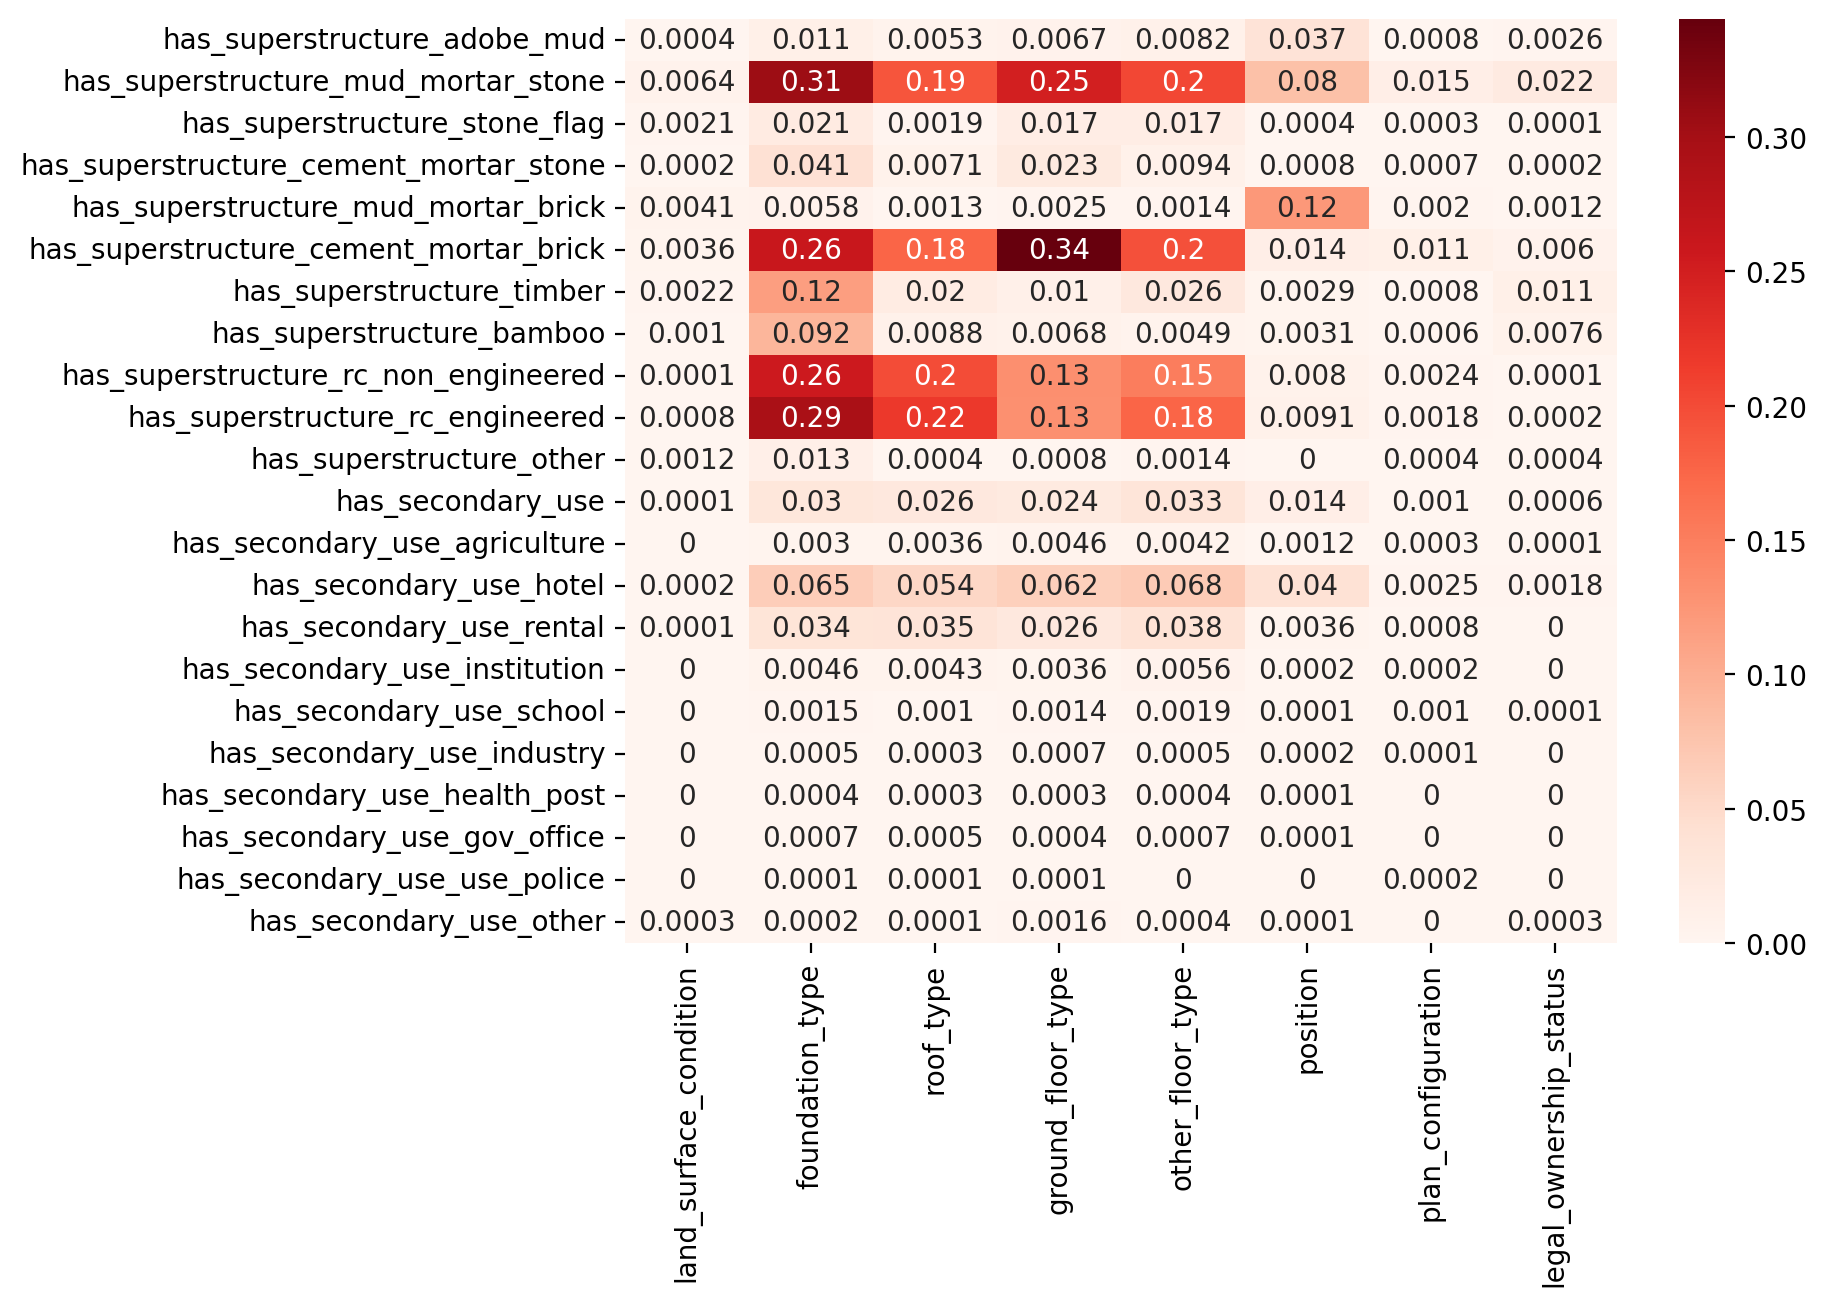

In [19]:
plot_cramers_v_corr_heatmap(train_features[cat_features + bin_features], 
                            features_x_axis=cat_features, 
                            features_y_axis=bin_features)

In [20]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for c in train_features.columns:
    if c in cat_features:
        data_encoded[c] = label.fit_transform(train_features[c])
    else:
        data_encoded[c] = train_features[c]

for f1 in bin_features:
    for f2 in cat_features:
        phi = matthews_corrcoef(data_encoded[f1], data_encoded[f2])
        if phi > 0.5 and f1 != f2:
            print(f"'{f1}' - '{f2}': {phi}")

There is no high correlation between any of those features. 

### Correlation between bin-bin features

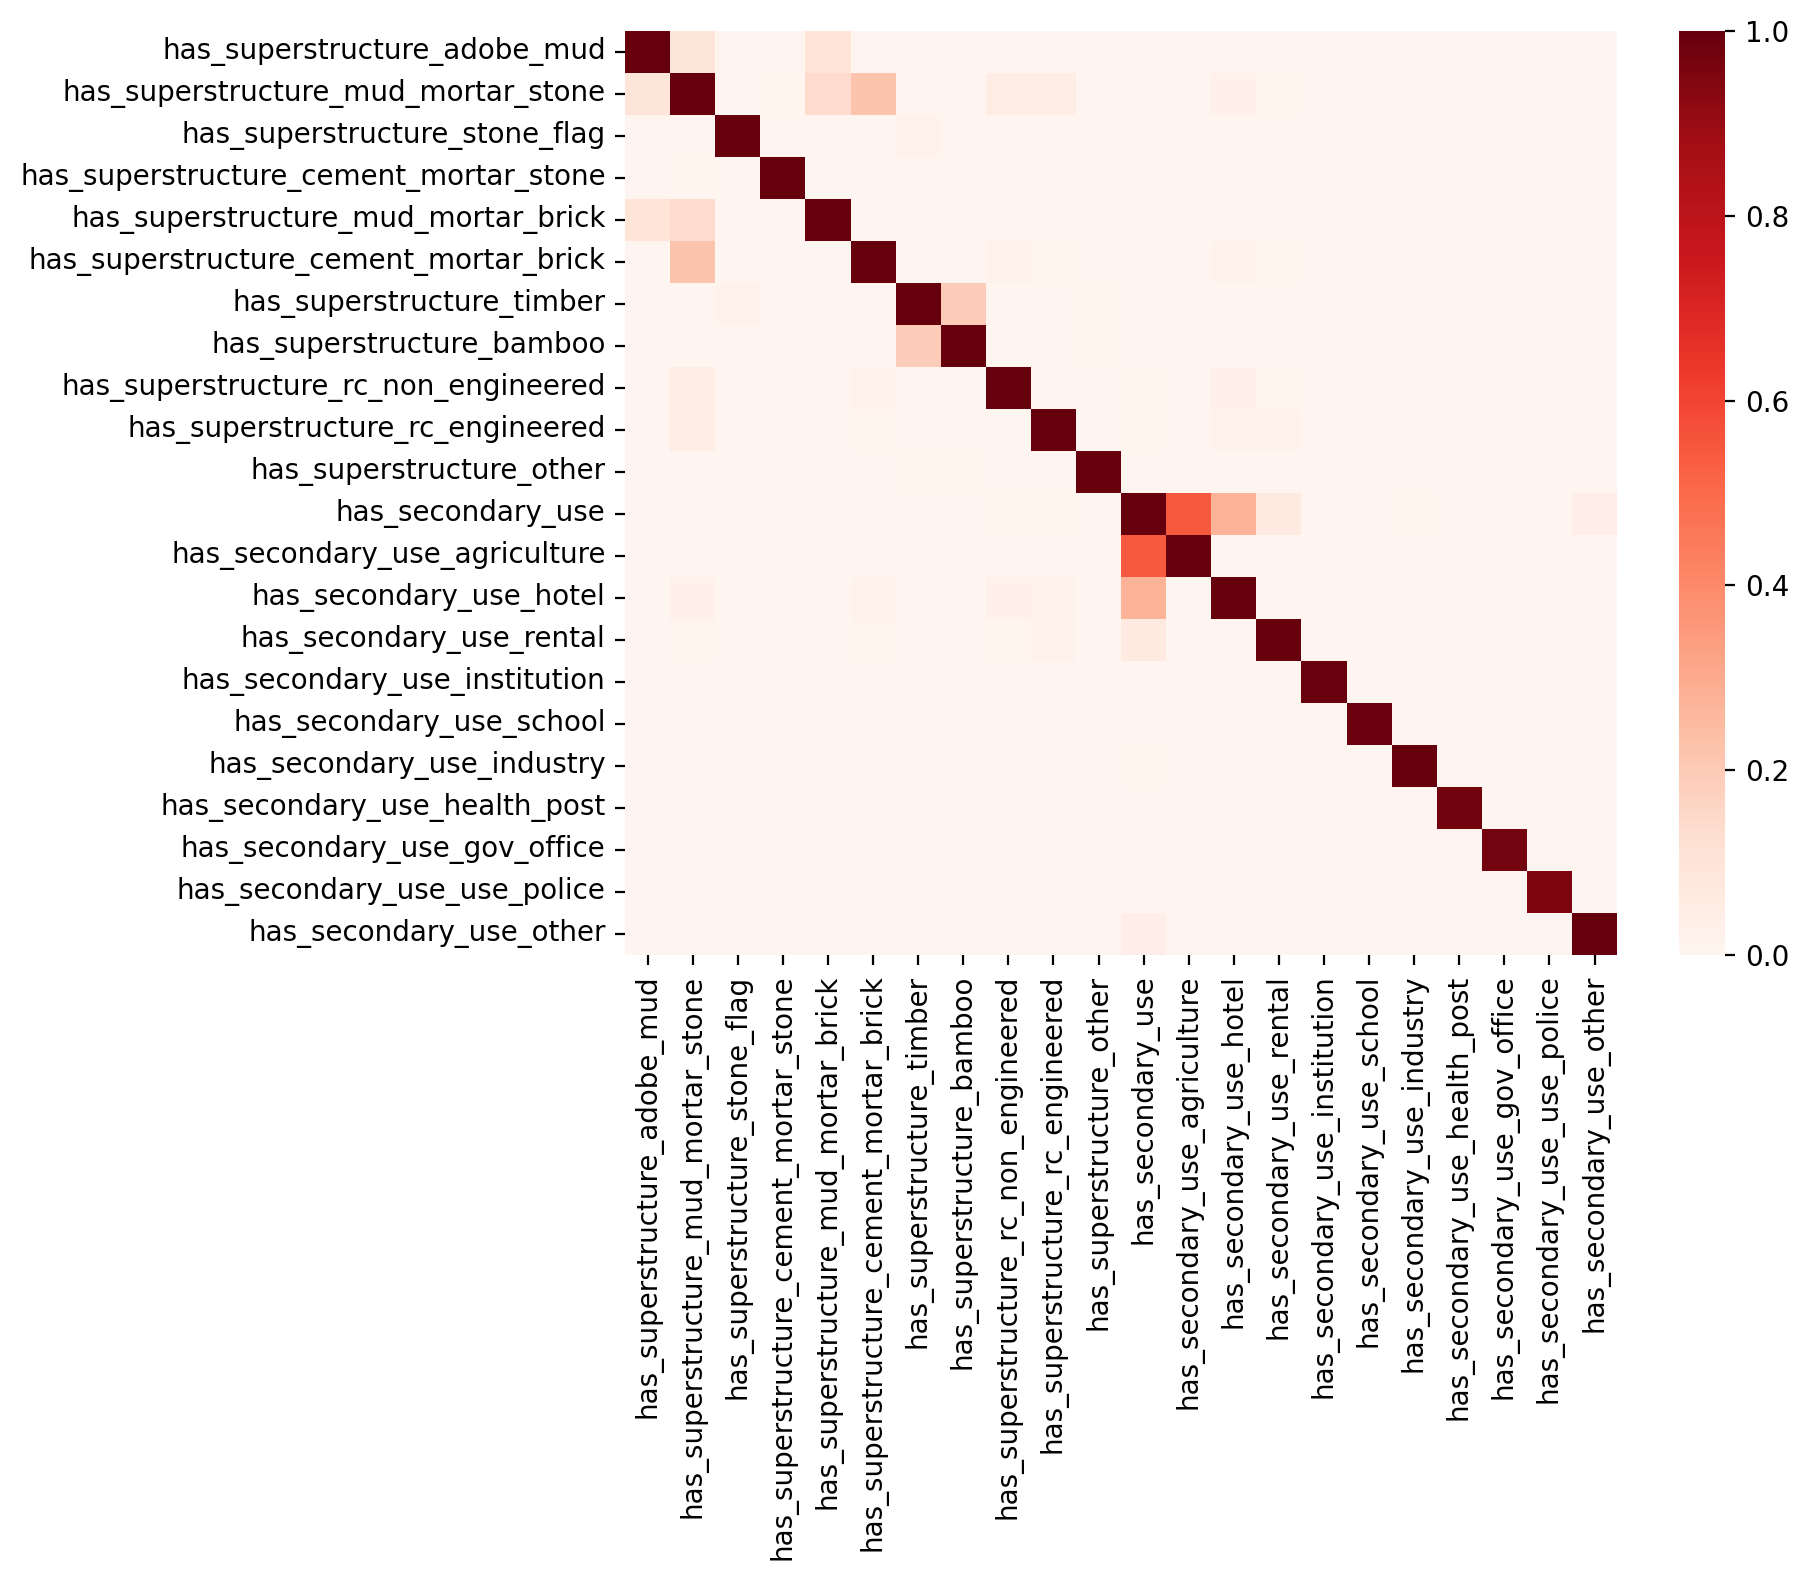

In [21]:
plot_cramers_v_corr_heatmap(train_features[bin_features], annotate_map=False)

Now I will test also a different measure: $\Phi$ aka. matthews_correlation

According to [this post](https://junye0798.com/post/everythin-you-need-to-know-about-correlation/) tetrachoric correlation is not quite so general. 

In [22]:
for f1 in bin_features:
    for f2 in bin_features:
        phi = matthews_corrcoef(train_features[f1], train_features[f2])
        if phi > 0.5 and f1 != f2:
            print(f"'{f1}' - '{f2}': {phi}")

'has_secondary_use' - 'has_secondary_use_agriculture': 0.7390585695838021
'has_secondary_use' - 'has_secondary_use_hotel': 0.5255641166302155
'has_secondary_use_agriculture' - 'has_secondary_use': 0.7390585695838021
'has_secondary_use_hotel' - 'has_secondary_use': 0.5255641166302155


So there is a high correlation between 'has_secondary_use' and 'has_secondary_use_agriculture' (MCC: 0.739). 
And also a smaller correlation between 'has_secondary_use' and ' has_secondary_use_hotel' (MCC: 0.526)